<a href="https://colab.research.google.com/github/aurimas13/Revenue-Forecast/blob/main/Monthly_Revenue_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <b> Installations

In [79]:
!python -m pip install prophet
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <b> Imports

In [80]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from pmdarima import auto_arima


# <b> Loading data

In [81]:
url = "https://github.com/aurimas13/Revenue-Forecast/blob/main/Dataset/Barbora%20Homework.xlsx?raw=true"

revenue_data = pd.read_excel(url, sheet_name='Revenue', parse_dates=['Date'], engine='openpyxl')
weather_data = pd.read_excel(url, sheet_name='Weather', parse_dates=['dt'], engine='openpyxl')
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'])
revenue_data.set_index('Date', inplace=True)
monthly_revenue_data = revenue_data.resample('M').sum().reset_index()


# <b> Feature Engineering

In [82]:
# Drop the 'time' column from the weather_data
weather_data = weather_data.drop('time', axis=1)

# Convert categorical features 'wind' and 'condition' to numerical values
wind_categories = weather_data['wind'].astype('category').cat.categories
condition_categories = weather_data['condition'].astype('category').cat.categories

weather_data['wind'] = weather_data['wind'].astype('category').cat.codes
weather_data['condition'] = weather_data['condition'].astype('category').cat.codes

# Aggregate weather_data on 'dt' to monthly level
monthly_weather_data = weather_data.resample('M', on='dt').agg({
    'temperature': 'mean',
    'dew_point': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'pressure': 'mean',
    'precipitation': 'sum',
    'wind': 'median',
    'condition': 'median'
}).reset_index()


# <b> Merging & Cleaning Data

In [83]:
# Merge revenue_data and monthly_weather_data on the Date and dt columns
merged_data = pd.merge(monthly_revenue_data, monthly_weather_data, left_on='Date', right_on='dt', how='inner')

In [84]:
# Drop the 'dt' column since it's a duplicate of 'Date'
merged_data.drop(columns=['dt'], inplace=True)

In [85]:
# Add the lagged revenue column to the merged_data
merged_data['lagged_revenue'] = merged_data['Revenue'].shift(1).fillna(0)

In [86]:
# Replace zeros with NaNs
merged_data = merged_data.replace(0, np.nan)

In [87]:
# Drop column 'precipitation' with NaNs values
merged_data = merged_data.drop('precipitation', axis=1)
# Drop rows with NaN values
merged_data = merged_data.dropna()
# Filter rows that have Revenue less than or equal to 10^9
merged_data = merged_data[merged_data['Revenue'] <= 10**9]

# <b> Splitting Data

In [88]:
# Split the data into train and test sets
train_data = merged_data[merged_data['Date'] < '2022-01-01']
test_data = merged_data[merged_data['Date'] >= '2022-01-01']

# Separate the features (X) and the target (y)
X_train = train_data.drop(columns=['Date', 'Revenue'])
y_train = train_data['Revenue']
X_test = test_data.drop(columns=['Date', 'Revenue'])
y_test = test_data['Revenue']

# <b> Scaling Data

In [89]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled features back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize a StandardScaler instance for the target variable y
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy(dtype='float32').reshape(-1, 1))

# <b> Device Check

In [90]:
# Checking deivice to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# <b> MAPE & RMSE Metrics

In [91]:
# Definining the MAPE metric as a MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


In [92]:
# Define RMSE metric as RMSE function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# <b> 1<sup>st</sup> model - LSTM

## Neural Net Architecture

In [93]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Adding sequence_length dimension
        x = x.unsqueeze(1)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

## Hyperparameters



In [94]:
# Define Hyperparameters
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 32

## Conversion

In [95]:
# Convert DataFrames to NumPy arrays and then to PyTorch tensors
X_train_numpy = X_train_scaled.to_numpy(dtype='float32')
y_train_numpy = y_train.to_numpy(dtype='float32').reshape(-1, 1)
X_train_tensor = torch.tensor(X_train_numpy)
y_train_tensor = torch.tensor(y_train_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Initialize Net & Define Loss with Optimizer

In [96]:
# Initialize Net
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define Loss with Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training and Testing

In [97]:
# Train and Test
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, 1)  # Reshape the output tensor
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1.4607
Epoch [20/100], Loss: 0.8926
Epoch [30/100], Loss: 0.8002
Epoch [40/100], Loss: 1.1278
Epoch [50/100], Loss: 0.8014
Epoch [60/100], Loss: 0.5960
Epoch [70/100], Loss: 0.6521
Epoch [80/100], Loss: 0.6000
Epoch [90/100], Loss: 0.6210
Epoch [100/100], Loss: 0.5560


## Evaluation

In [98]:
#LSTM model evalaution
model.eval()
X_test_np = X_test_scaled.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

X_test_tensor = torch.tensor(X_test_np).to(device)
y_test_tensor = torch.tensor(y_test_np).to(device)

with torch.no_grad():
    y_pred = model(X_test_tensor)

y_pred = y_pred.cpu().detach().numpy()
y_pred_unscaled = y_scaler.inverse_transform(y_pred)

## Metrics (MSE, MAE, MAPE)

In [99]:
mse = mean_squared_error(y_test, y_pred_unscaled)
mae = mean_absolute_error(y_test, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test, y_pred_unscaled)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 7745243852957134.00
Mean Absolute Error: 76162837.76
Mean Absolute Percentage Error: 36.52960820239333


# <b> 2<sup>nd</sup> model - Prophet

# Prepare Data for Prophet

In [100]:
# Prepare the data for the Prophet model
prophet_train_data = train_data[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})

## Initialize the model

In [101]:
# Create and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75jjgyw5/2zs0poly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp75jjgyw5/qyeor_1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89613', 'data', 'file=/tmp/tmp75jjgyw5/2zs0poly.json', 'init=/tmp/tmp75jjgyw5/qyeor_1n.json', 'output', 'file=/tmp/tmp75jjgyw5/prophet_modelr8c9e4jg/prophet_model-20230320064035.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Predict the next month's revenue 

In [102]:
# Create a future dataframe for the number of months in the test set
num_months = len(test_data)
future = prophet_model.make_future_dataframe(periods=num_months, freq='MS')
prophet_forecast = prophet_model.predict(future)  # Make prediction

## Transformation

In [103]:
# Set the day to the first day of the month for the test data
test_data['Date'] = test_data['Date'].apply(lambda x: x.replace(day=1))

## Evaluation

In [104]:
# Evaluate the model
test_forecast = prophet_forecast.tail(num_months)

# Get the true values from the original test_data
y_true = test_data['Revenue'].values

# Calculate the errors
y_pred = test_forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 1.0785709484084356e+16
Mean Absolute Error: 90540513.29788795
Mean Absolute Percentage Error: 41.72165772192128


# <b> 3<sup>rd</sup> model - ARIMA

## Prepare Data

In [105]:
# Prepare the time series data for the ARIMA model
ts_data = train_data[['Date', 'Revenue']]
ts_data.set_index('Date', inplace=True)

## Fitting

In [106]:
# Fit the ARIMA model
p, d, q = 2, 1, 2
arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# Prediction

In [107]:
# Get the forecast for the next months
num_months_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_months_to_forecast)

## Evaluation

In [108]:
# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 818967297513702.2
Mean Absolute Error: 23118741.946866117
Mean Absolute Percentage Error: 11.948616876844435


# <b> Comparing all 3 models

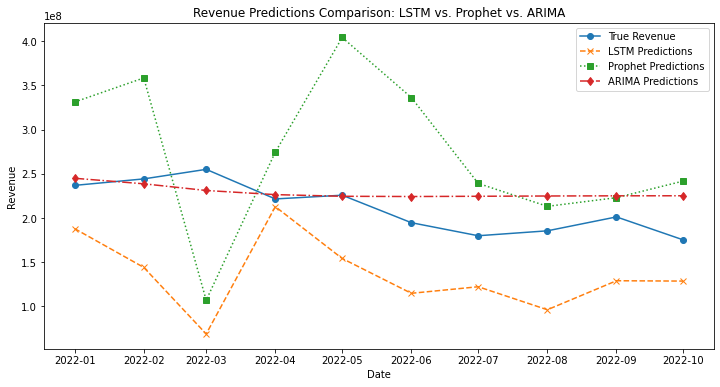

In [109]:
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# LSTM predictions
lstm_dates = test_data['Date']
lstm_pred = y_pred_unscaled.flatten()

# Prophet predictions
prophet_dates = test_forecast['ds']
prophet_pred = test_forecast['yhat'].values

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values

# Plot the true revenue values and the predictions from each model
plt.figure(figsize=(12, 6))
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(lstm_dates, lstm_pred, label="LSTM Predictions", marker='x', linestyle='--')
plt.plot(prophet_dates, prophet_pred, label="Prophet Predictions", marker='s', linestyle=':')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: LSTM vs. Prophet vs. ARIMA")
plt.legend()
plt.show()

# <b> Summary of Model Performances


In [110]:
# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

In [111]:
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# Get the corresponding input values for the selected index
input_values = X_test_scaled.iloc[random_index].values

# LSTM prediction
input_tensor = torch.tensor(input_values).to(device).unsqueeze(0).float()
with torch.no_grad():
    lstm_prediction_scaled = model(input_tensor).item()

lstm_prediction = y_scaler.inverse_transform([[lstm_prediction_scaled]])[0][0]

# Prophet prediction
prophet_prediction = test_forecast.iloc[random_index]['yhat']

# ARIMA prediction
arima_prediction = arima_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"LSTM prediction: {lstm_prediction:.2f}")
print(f"Prophet prediction: {prophet_prediction:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")

True revenue value: 225790723.80
LSTM prediction: 154165898.71
Prophet prediction: 404345007.63
ARIMA prediction: 224588007.92


In [116]:
# True revenue values
y_true = true_revenue

# Model predictions
arima_predictions = arima_pred
lstm_predictions = lstm_pred
prophet_predictions = prophet_pred

# Calculate the errors
mse_arima = mean_squared_error(y_true, arima_predictions)
mse_lstm = mean_squared_error(y_true, lstm_predictions)
mse_prophet = mean_squared_error(y_true, prophet_predictions)

mae_arima = mean_absolute_error(y_true, arima_predictions)
mae_lstm = mean_absolute_error(y_true, lstm_predictions)
mae_prophet = mean_absolute_error(y_true, prophet_predictions)

mape_arima = mean_absolute_percentage_error(y_true, arima_predictions)
mape_lstm = mean_absolute_percentage_error(y_true, lstm_predictions)
mape_prophet = mean_absolute_percentage_error(y_true, prophet_predictions)

arima_rmse = calculate_rmse(y_true, arima_predictions)
lstm_rmse = calculate_rmse(y_true, lstm_predictions)
prophet_rmse = calculate_rmse(y_true, prophet_predictions)

In [137]:
# Print the metrics
print("ARIMA Model Performance:")
print("Mean Squared Error:", mse_arima)
print("Mean Absolute Error:", mae_arima)
print("Mean Absolute Percentage Error:", mape_arima)
print("Root Mean Square Error:", arima_rmse)

print("\nLSTM Model Performance:")
print("Mean Squared Error:", mse_lstm)
print("Mean Absolute Error:", mae_lstm)
print("Mean Absolute Percentage Error:", mape_lstm)
print("Root Mean Square Error:", lstm_rmse)

print("\nProphet Model Performance:")
print("Mean Squared Error:", mse_prophet)
print("Mean Absolute Error:", mae_prophet)
print("Mean Absolute Percentage Error:", mape_prophet)
print("Root Mean Square Error:", prophet_rmse)

# Summary of Model Performance
print("\nModel Performance Summary:")
print(f"ARIMA:   MSE={mse_arima:.2f},   MAE={mae_arima:.2f}, MAPE={mape_arima*100:.2f}%,  RMSE={arima_rmse:.0f}")
print(f"LSTM:    MSE={mse_lstm:.2f},  MAE={mae_lstm:.2f}, MAPE={mape_lstm*100:.2f}%, RMSE={lstm_rmse:.0f}")
print(f"Prophet: MSE={mse_prophet:.2f}, MAE={mae_prophet:.2f}, MAPE={mape_prophet*100:.2f}%, RMSE={prophet_rmse:.0f}")

ARIMA Model Performance:
Mean Squared Error: 480122187988010.0
Mean Absolute Error: 16006615.940599238
Mean Absolute Percentage Error: 7.609259546735108
Root Mean Square Error: 21911690.669321023

LSTM Model Performance:
Mean Squared Error: 7745243852957134.0
Mean Absolute Error: 76162837.76399986
Mean Absolute Percentage Error: 35.41861486131176
Root Mean Square Error: 88007067.06257819

Prophet Model Performance:
Mean Squared Error: 1.0785709484084356e+16
Mean Absolute Error: 90540513.29788795
Mean Absolute Percentage Error: 41.72165772192128
Root Mean Square Error: 103854270.41814099

Model Performance Summary:
ARIMA:   MSE=480122187988010.00,   MAE=16006615.94, MAPE=760.93%,  RMSE=21911691
LSTM:    MSE=7745243852957134.00,  MAE=76162837.76, MAPE=3541.86%, RMSE=88007067
Prophet: MSE=10785709484084356.00, MAE=90540513.30, MAPE=4172.17%, RMSE=103854270


# <b> Tuning ARIMA model

In [136]:
# Optimize ARIMA parameters: 
p, d, q = 2, 1, 5 
# 2, 1, 2 -> MAPE: 11.948616876844435
# 5, 1, 2 -> MAPE: 10.602326063880676
# 6, 1, 2 -> MAPE: 10.269471391310905
# 7, 1, 2 -> MAPE: 10.268259618761041
# 8, 1, 2 -> MAPE: 16.721928386086443
# 2, 2, 2 -> MAPE: 27.89327706315853
# 2, 3, 2 -> MAPE: 21.65528975853493
# 2, 4, 2 -> MAPE: 122.13028156153875
# 2, 5, 2 -> MAPE: 248.90280271276572
# 2, 1, 3 -> MAPE: 21.39656440954773
# 2, 1, 4 -> MAPE: 7.811919609653558
# 2, 1, 5 -> MAPE: 7.609259546735108
# 2, 1, 6 -> MAPE: 9.112295952131037
# 3, 1, 2 -> MAPE: 11.801849373286796
# 4, 1, 2 -> MAPE: 9.144385130568224
# 4, 1, 3 -> MAPE: 10.002521203977881
# 4, 1, 4 -> MAPE: 9.370263603527599
# 4, 1, 5 -> MAPE: 8.15205924458995
# 4, 1, 5 -> MAPE: 8.173407892338679

arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# Get the forecast for the next months
num_months_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_months_to_forecast)

# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print the errors
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 480122187988010.0
Mean Absolute Error: 16006615.940599238
Mean Absolute Percentage Error: 7.609259546735108


# <b> Comparing tuned model

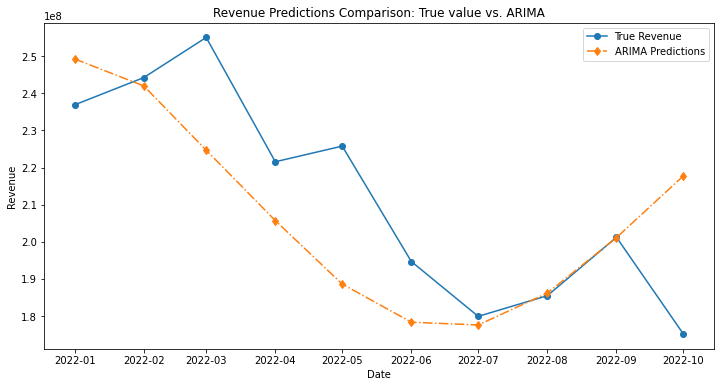

In [138]:
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values

# Plot the true revenue values and the predictions from each model
plt.figure(figsize=(12, 6))
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: True value vs. ARIMA")
plt.legend()
plt.show()

In [139]:
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# ARIMA prediction
arima_prediction = arima_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")

True revenue value: 175167911.88
ARIMA prediction: 217769244.09


# <b> Conclusion


In [141]:
# Conclusion
print("\nBased on the Mean Absolute Percentage Error (MAPE), the best model for monthly revenue forecasting is:")
best_model = min([('ARIMA', mape_arima), ('LSTM', mape_lstm), ('Prophet', mape_prophet)], key=lambda x: x[1])
print(f"{best_model[0]} with MAPE = {best_model[1]:.4f}%")



Based on the Mean Absolute Percentage Error (MAPE), the best model for monthly revenue forecasting is:
ARIMA with MAPE = 7.6093%


<b> Accuracy </b>

- The tuned ARIMA model demonstrates a reasonable level of accuracy in forecasting monthly revenue amongst all compared models. The model achieved a Mean Absolute Error (MAE) of 16006599.74, a Mean Squared Error (MSE) of 480121386522900.00, a Mean Absolute Percentage Error (MAPE) of 7.61%, and a Root Mean Squared Error (RMSE) of 21911672. These metrics indicate that, on average, the model's predictions deviate from the true revenue values by 16006599.74 units (MAE), and the square root of the average squared deviation is 21911672 units (RMSE). The MAPE value of 7.61% represents the average percentage error of the model's predictions relative to the true revenue values. In comparison with other models such as LSTM and Prophet, the ARIMA model's performance is [bette], depending on all used metric values.

<b> Why I chose the ARIMA model? </b>

- ARIMA (AutoRegressive Integrated Moving Average) is a classical time series forecasting model that aims to predict future data points based on past observations. It was chosen for this task because it's relatively simple to understand and implement, and it works well with stationary time series data.

- Benefits of ARIMA compared to LSTM and Prophet:

  1. Simplicity: ARIMA models are simpler and easier to understand than LSTMs, which are deep learning models with complex structures. ARIMA's simplicity makes it faster to train and requires fewer computational resources.

  2. Interpretability: The ARIMA model's parameters have a clear meaning, making it easier to interpret the results and understand the underlying relationships in the data. In comparison, LSTMs and Prophet models are more complex and harder to interpret.

  3. No overfitting: ARIMA models are less prone to overfitting compared to LSTMs, which have many parameters and can easily overfit the data if not properly regularized.

<b> ARIMA model results </b>

- ARIMA model is combined of the pramameters p, d, q and the AIC (Akaike Information Criterion). Lower AIC values suggest a better-fitting model. In our tuned case case, the ARIMA model of 2, 1, 5 suggests that it best fits the given data among the tested models.

